In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [8]:
from habitat.sims.habitat_simulator.actions import HabitatSimActions

from habitat_dataset import get_dataset, HabitatDataset
from model import get_model

from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
import cv2

ACTIONS = {v: k for k, v in HabitatSimActions._known_actions.items()}

transform  = transforms.ToTensor()
transform_ = transforms.ToPILImage()
dataset = HabitatDataset('test/000001')

i = 20
rgb, _, _, action, meta, _ = dataset[i]

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# Direct (DD-PPO setup) `[4.x]`
* SE-ResNeXt-50
* GroupNorm
* normalize RGB channels

In [10]:
from habitat_baselines.rl.ddppo.policy.resnet_policy import ResNetEncoder
from habitat_baselines.rl.ddppo.policy import resnet
from habitat_baselines.common.utils import CategoricalNet
from gym import spaces

class DirectImitation(nn.Module):
    def __init__(self, resnet_model='resnet18', baseplanes=32, ngroups=16, hidden_size=512, dim_actions=4):
        super().__init__()
    
        self.visual_encoder = ResNetEncoder(
            spaces.Dict({'rgb': spaces.Box(low=0, high=255, shape=(256, 256, 3), dtype='uint8')}),
            baseplanes=baseplanes,
            ngroups=ngroups,
            make_backbone=getattr(resnet, resnet_model),
            normalize_visual_inputs=True
        )   
    
        self.visual_fc = nn.Sequential(
            Flatten(),
            nn.Linear(np.prod(self.visual_encoder.output_shape), hidden_size),
            nn.ReLU(True)
        )
        
        self.action_fc = nn.Linear(hidden_size, dim_actions)
        
        nn.init.orthogonal_(self.action_fc.weight, gain=0.01)
        nn.init.constant_(self.action_fc.bias, 0)

    def forward(self, x): 
        rgb = x[0]
        rgb_vec = self.visual_encoder({'rgb': rgb})

        return self.action_fc(self.visual_fc(rgb_vec))

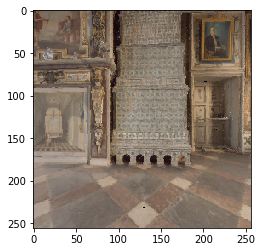

In [11]:
plt.imshow(np.uint8(rgb))

# Conditional Imitation `[v3.x]`

Let's try conditioning on:
* **zero-centered delta vector** (DD-PPO fig3)

In [15]:
class ConditionalImitation(DirectImitation):
    def __init__(self, resnet_model='resnet18', baseplanes=32, ngroups=16, hidden_size=512, dim_actions=4, meta_size=2):
        super().__init__(resnet_model, baseplanes, ngroups, hidden_size, dim_actions)

        meta_embedding_size = hidden_size // 16
        self.meta_fc = nn.Sequential(
            nn.Linear(meta_size, meta_embedding_size),
            nn.ReLU(True)
        )

        self.action_fc = nn.Linear(hidden_size + meta_embedding_size, dim_actions)

    def forward(self, x):
        rgb, meta = x
        rgb_vec = self.visual_encoder({'rgb': rgb})

        return self.action_fc(torch.cat([self.visual_fc(rgb_vec), self.meta_fc(meta)], dim=1))

In [16]:
net = ConditionalImitation()

net((rgb.unsqueeze(dim=0), meta.unsqueeze(dim=0))).detach()

tensor([[-0.1152,  0.1680,  0.1439, -0.1059]])

In [17]:
torch.save(net.state_dict(), 'models/001/model_000.t7')

---

In [10]:
for rgb, _, _, action, _ in dataset:
    img = np.array(transform_(rgb))

    cv2.putText(img, 'Predicted: {}'.format(ACTIONS[(net(rgb.unsqueeze(dim=0)).detach()).argmax().item()]),
        (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255,255,255),
        2)

    cv2.putText(img, 'Actual:    {}'.format(ACTIONS[action.argmax().item()]),
        (10, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255,255,255),
        2)

    cv2.imshow('rgb', img)
    cv2.waitKey(1)